In [201]:
from speech_pause_indicator import speech, pause ; import setup; import matplotlib.pyplot as plt; import numpy as np

In [202]:
##https://pyts.readthedocs.io/en/stable/auto_examples/metrics/plot_dtw.html
from pyts.datasets import load_gunpoint; import math
from pyts.metrics import dtw, itakura_parallelogram, sakoe_chiba_band
from pyts.metrics.dtw import (cost_matrix, accumulated_cost_matrix, _return_path, _blurred_path_region)
import itertools; import statistics

In [234]:
# Original distance / alignment length
# Maximum distance = number of points in the alignment path * largest difference between amplitude of x and y, 
# but this noramlization constant makes the new distance very small

def normalize_distance(x, y, path, dist, method):
    plt.figure(figsize=(8, 4.5))                                
    max_a = max(x)
    min_a = min(y)
    normal_cons = len(path[0])
    nor_dist = dist / (normal_cons)
#     plt.title('dtw' + '_' + method + ' distance: ' + str(nor_dist));
    plt.title('dtw %s distance: %.3f' %(method, nor_dist));    
    
    plt.plot(path[0], path[1]);
    
# unit of distance = amplitude / portion of the alignment path

In [204]:
# pyts - classic
def classic(x, y, xlabel, ylabel, time1_lst, time2_lst, sr, speech_x, speech_y):
    method = 'classic'
    dtw_classic, path_classic = dtw(x, y, dist='square', method=method, return_path=True)
    path = path_classic
    dist = dtw_classic
    normalize_distance(x, y, path, dist, method)    
    alignment_err(path, file1, file2, seg1_1, seg1_2, seg2_1, seg2_2, time1_lst, time2_lst, xlabel, ylabel, sr, speech_x, speech_y)

#     return path, dist

In [205]:
# pyts itakura

def itakura(x, y, xlabel, ylabel, time1_lst, time2_lst, sr, speech1, speech2):

    method = 'itakura'
    slope = 1.2
    dtw_itakura, path_itakura = dtw(
        x, y, dist='square', method='itakura',
        options={'max_slope': slope}, return_path=True
    )
    parallelogram = itakura_parallelogram(n_timestamps_1, n_timestamps_2,
                                          max_slope=slope)
    matrix_itakura = np.zeros((n_timestamps_1 + 1, n_timestamps_2 + 1))
    for i in range(n_timestamps_1):
        matrix_itakura[i, np.arange(*parallelogram[:, i])] = 0.5
    matrix_itakura[tuple(path_itakura)] = 1.
    path = path_itakura
    dist = dtw_itakura
    normalize_distance(x, y, path, dist, method)
    alignment_err(path, file1, file2, seg1_1, seg1_2, seg2_1, seg2_2, time1_lst, time2_lst, xlabel, ylabel, sr, speech1, speech2);
    
    #return path, dist

In [206]:
# pyts sakoechiba

def sakoechiba(x, y, xlabel, ylabel, time1_lst, time2_lst, sr, speech_x, speech_y):
    method = "sakoechiba"
    window_size = 0.1
    dtw_sakoechiba, path_sakoechiba = dtw(
        x, y, dist='square', method='sakoechiba',
        options={'window_size': window_size}, return_path=True
    )
    band = sakoe_chiba_band(n_timestamps_1, n_timestamps_2,
                            window_size=window_size)
    matrix_sakoechiba = np.zeros((n_timestamps_1 + 1, n_timestamps_2 + 1))
    for i in range(n_timestamps_1):
        matrix_sakoechiba[i, np.arange(*band[:, i])] = 0.5
    matrix_sakoechiba[tuple(path_sakoechiba)] = 1.

    path = path_sakoechiba
    dist = dtw_sakoechiba
    normalize_distance(x, y, path, dist, method)
    alignment_err(path, file1, file2, seg1_1, seg1_2, seg2_1, seg2_2, time1_lst, time2_lst, xlabel, ylabel, sr, speech_x, speech_y)
    
    # return path, dist

In [207]:
def round_down(num, divisor):
    return num - (num%divisor)

In [208]:
def multiscale(x, y, xlabel, ylabel, time1_lst, time2_lst, sr, speech_x, speech_y):
    method = "multiscale"
    x = np.array(x)
    y = np.array(y)
    
    resolution, radius = 5, 2
    dtw_multiscale, path_multiscale = dtw(
        x, y, dist='square', method='multiscale',
        options={'resolution': resolution, 'radius': radius}, return_path=True
    )
    
    x = x[0: round_down(len(x), resolution)]
    y = y[0: round_down(len(y), resolution)]
    
    x_padded = x.reshape(-1, resolution).mean(axis=1)
    y_padded = y.reshape(-1, resolution).mean(axis=1)

    cost_mat_res = cost_matrix(x_padded, y_padded, dist='square', region=None)
    acc_cost_mat_res = accumulated_cost_matrix(cost_mat_res)
    path_res = _return_path(acc_cost_mat_res)

    multiscale_region = _blurred_path_region(
        n_timestamps_1, n_timestamps_2, resolution, x_padded.size, y_padded.size,
        path_res,
        radius=radius
    )
    matrix_multiscale = np.zeros((n_timestamps_1 + 1, n_timestamps_2 + 1))
    for i in range(n_timestamps_1):
        matrix_multiscale[i, np.arange(*multiscale_region[:, i])] = 0.5
    matrix_multiscale[tuple(path_multiscale)] = 1.

    path = path_multiscale
    dist = dtw_multiscale
    
    normalize_distance(x, y, path, dist, method)
    alignment_err(path, file1, file2, seg1_1, seg1_2, seg2_1, seg2_2, time1_lst, time2_lst, xlabel, ylabel, sr, speech_x, speech_y)
     
    # return path, dist

In [209]:
def make_samples(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, sr):
    from scipy.io import wavfile 
    capstone_dir = "/Users/ninismacbook/other_docs/Y4S1/capstone" 
    
    file1_path = capstone_dir + "/py_converted/" + file1 ; file2_path = capstone_dir + "/py_converted/" + file2
    
    samplerate, query = wavfile.read(file1_path) ; samplerate, ref = wavfile.read(file2_path)
    new_sr = samplerate/sr
    # If input sr = 4410, then new_sr = 44100/4410 = 10 (samplerate from py_converted is always 44100)
    
    query_sample = query[int(samplerate*seg1_1): int(samplerate*seg1_2)]
    ref_sample = ref[int(samplerate*seg2_1): int(samplerate*seg2_2)]
    
    longer_query_len = len(query_sample)
    a = len(ref_sample) 
    if a > longer_query_len:
        longer_query_len = a
    
    new_query_sample = []
    new_ref_sample = []
    
    query_s = []
    ref_s = []
    
    # speech pause indicator uses 8k voice samples. Using the segment timestamps to store speech pause array
    sr_speech = 8000
    s1 = speech(file1)[1][int(sr_speech*seg1_1):int(sr_speech*seg1_2)]
    s2 = speech(file2)[1][int(sr_speech*seg2_1):int(sr_speech*seg2_2)]
    
    
    for i in range(int(longer_query_len // new_sr)):
        
        # Only append when the index is within the length of new_query_sample and new_ref_sample
        if int(i*new_sr) < len(query_sample):
            new_query_sample.append(query_sample[int(i*new_sr)])
        if int(i*new_sr) < len(ref_sample):
            new_ref_sample.append(ref_sample[int(i*new_sr)])            
            
        if int(i* sr_speech / sr) < len(s1):
            query_s.append(s1[int(i* sr_speech / sr)])
            
        if int(i* sr_speech / sr) < len(s2):            
            ref_s.append(s2[int(i* sr_speech /sr)])


    return new_query_sample, new_ref_sample, sr, query_s, ref_s

def get_word_xy(file1, time1, seg1_1, seg1_2, file2, time2, seg2_1, seg2_2, sr):
    
    queries = make_samples(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, sr)
    query = queries[0]
    ref = queries[1]
    x = (time1 - seg1_1)/(seg1_2 - seg1_1) * len(query)
    y = (time2 - seg2_1)/(seg2_2 - seg2_1) * len(ref)
    return x, y

def alignment_err(path, file1, file2, seg1_1, seg1_2, seg2_1, seg2_2, time1_lst, time2_lst, xlabel, ylabel, sr, speech1, speech2):
    colors = ['red', 'g', 'b', 'm', 'brown', '#d89743', 'grey', 'c', 'orange', 'g', 'b', 'm', 'red']
    err = []
    for i in range(len(time1_lst)):
        x_axis, y_axis = get_word_xy(file1, time1_lst[i], seg1_1, seg1_2, file2, time2_lst[i], seg2_1, seg2_2, sr)

        plt.axvline(x_axis, color = colors[i])
        plt.hlines(y_axis, 0, x_axis+3000, color = colors[i])
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        
        x_val = list(itertools.chain(*np.where(np.abs(path[0] - x_axis) < 1)))[0]
        y_val = list(itertools.chain(*np.where(np.abs(path[1] - y_axis) < 1)))[0]

        warp_y = path[1][x_val]
        warp_x = path[0][y_val]
        
        e = (np.abs(warp_x - x_axis) + np.abs(warp_y - y_axis))/sr
        err.append(e)    # unit = second
        
    median = statistics.median(err)
    err_sum = sum(err)
    
    print('Avg err (s): %.3f. Median err (s): %.3f' %(err_sum/len(time1_lst), median))
    print('Stretch speech: %.3f \nStretch pause: %.3f. \nStretch unaligned: %.3f. \nStretch overall: %.3f.' %stretch(path, speech1, speech2))
    print()
    
# deviation function

def deviation(rho, theta):
    dev = 0
    if rho >= theta and rho <= math.pi/2:
        dev = (rho-theta)/(math.pi/2-theta)
    else:
        dev = (theta - rho)/theta
    return dev

def stretch(path, speech_1, speech_2):
    len_x = max(path[0])
    len_y = max(path[1])
    xs = path[0]
    ys = path[1]
    theta = math.atan(len_y/len_x)    
    numerator = 0
    denominator = 0
    
    stretch_speech = 0
    stretch_pause = 0
    stretch_others = 0
    overall_stretch = 0

    # For 1 point in the warping path x, y
    # xs[i] = index of the point in the original query that dtw uses to align x
    # ys[i] = index of the point in the original reference query that dtw uses to align y                  
    
    # length of path = len(path[0]) = len(path[1])
    for i in range(len(path[0])-1):
        if xs[i+1]-xs[i] == 0:
            rho_i = math.pi/2
        else:
            rho_i = math.atan((ys[i+1]-ys[i]) / (xs[i+1]-xs[i]))

        dev_rho_i = deviation(rho_i, theta)
        numerator = dev_rho_i*math.sqrt((xs[i+1]-xs[i])**2 + (ys[i+1]-ys[i])**2)
        denominator = denominator + math.sqrt((xs[i+1]-xs[i])**2 + (ys[i+1]-ys[i])**2)

        sp1 = speech_1[xs[i]]
        sp2 = speech_2[ys[i]]
        
        if sp1 == sp2 == 1: # Add the deviation to either speech, pause, or not aligned
            stretch_speech = stretch_speech + numerator
        elif sp1 == sp2 == 0:
            stretch_pause = stretch_pause + numerator
        else:
            stretch_others = stretch_others+ numerator
            
    overall_stretch = (stretch_speech + stretch_pause + stretch_others)/denominator
    
    return stretch_speech/denominator, stretch_pause/denominator, stretch_others/denominator, overall_stretch

In [210]:
sr = 8000

# TORGO: Except in the winter

In [232]:
file1, seg1_1, seg1_2 = "torgo-healthy.wav", 2, 3.7
file2, seg2_1, seg2_2 = "torgo-patient.wav", 2.5, 5

x, y, samplerate, speech_x, speech_y = make_samples(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, sr)
n_timestamps_1, n_timestamps_2 = len(x), len(y)

xlabel = "Except in the winter - healthy" ;  ylabel = "Except in the winter - patient"
time1_lst = [2.34, 2.86, 3.03, 3.26] ; time2_lst = [2.8, 3.86, 4.03, 4.20]

In [212]:
setup.play_samples(x, y, samplerate)

Avg err (s): 0.696. Median err (s): 0.817
Stretch speech: 0.000 
Stretch pause: 0.489. 
Stretch unaligned: 0.267. 
Stretch overall: 0.757.



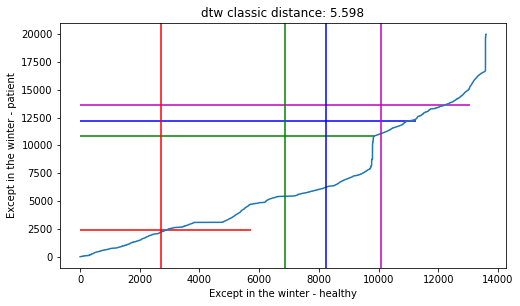

In [235]:
classic(x, y, xlabel, ylabel, time1_lst, time2_lst, sr, speech_x, speech_y)

Avg err (s): 0.118. Median err (s): 0.132
Stretch speech: 0.000 
Stretch pause: 0.586. 
Stretch unaligned: 0.148. 
Stretch overall: 0.734.



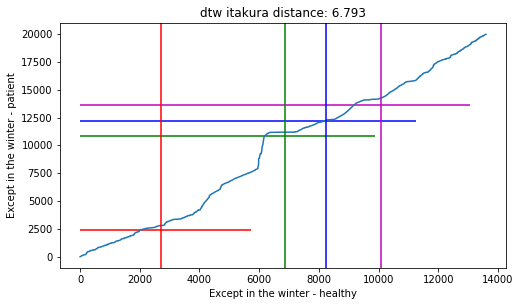

In [236]:
itakura(x, y, xlabel, ylabel, time1_lst, time2_lst, sr, speech_x, speech_y)

Avg err (s): 0.107. Median err (s): 0.126
Stretch speech: 0.000 
Stretch pause: 0.562. 
Stretch unaligned: 0.192. 
Stretch overall: 0.754.



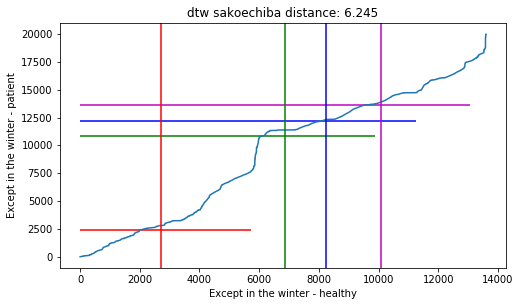

In [237]:
sakoechiba(x, y, xlabel, ylabel, time1_lst, time2_lst, sr, speech_x, speech_y)

Avg err (s): 0.516. Median err (s): 0.518
Stretch speech: 0.000 
Stretch pause: 0.537. 
Stretch unaligned: 0.241. 
Stretch overall: 0.777.



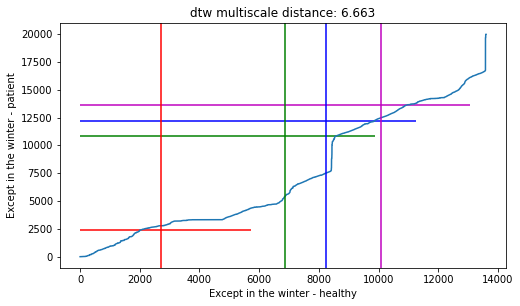

In [238]:
multiscale(x, y, xlabel, ylabel, time1_lst, time2_lst, sr, speech_x, speech_y)

# Torgo: when the ooze or snow or ice prevents

In [239]:
file1, seg1_1, seg1_2 = "torgo-healthy.wav", 3.7, 6.50
file2, seg2_1, seg2_2 = "torgo-patient.wav", 5, 11.38
x, y, samplerate, speech_x, speech_y = make_samples(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, sr)
n_timestamps_1, n_timestamps_2 = len(x), len(y)
time1_lst = [3.94, 4.03, 4.38, 4.8, 5.1, 5.54, 5.73, 6.18] ;
time2_lst = [7.07, 7.26, 7.78, 8.21, 8.53, 9.57, 9.9, 10.76]
xlabel = "Healthy: when the ooze or snow or ice presents" ;  ylabel = "patient"

In [218]:
setup.play_samples(x, y, samplerate)

Avg err (s): 0.410. Median err (s): 0.506
Stretch speech: 0.010 
Stretch pause: 0.404. 
Stretch unaligned: 0.455. 
Stretch overall: 0.869.



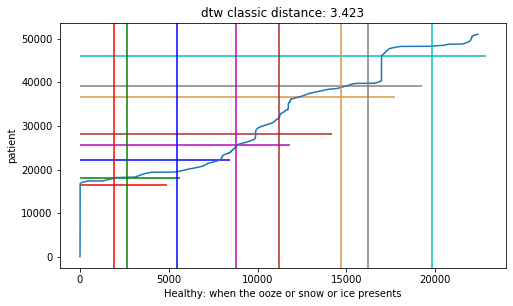

In [240]:
classic(x, y, xlabel, ylabel, time1_lst, time2_lst, sr, speech_x, speech_y)

Avg err (s): 1.065. Median err (s): 1.125
Stretch speech: 0.009 
Stretch pause: 0.603. 
Stretch unaligned: 0.220. 
Stretch overall: 0.832.



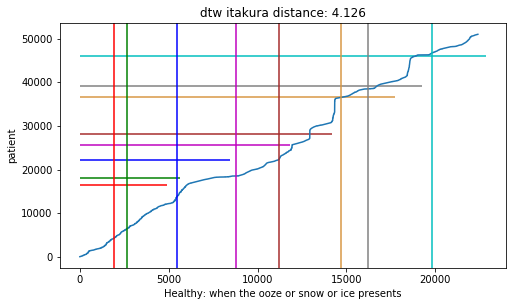

In [241]:
itakura(x, y, xlabel, ylabel, time1_lst, time2_lst, sr, speech_x, speech_y)

Avg err (s): 0.845. Median err (s): 0.970
Stretch speech: 0.010 
Stretch pause: 0.582. 
Stretch unaligned: 0.233. 
Stretch overall: 0.825.



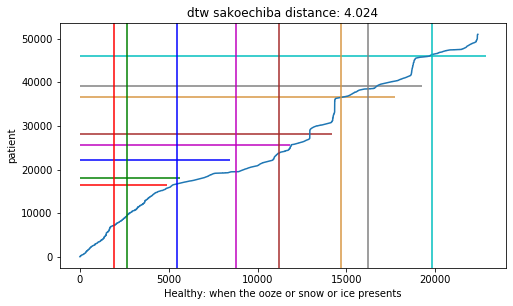

In [242]:
sakoechiba(x, y, xlabel, ylabel, time1_lst, time2_lst, sr, speech_x, speech_y)

Avg err (s): 0.424. Median err (s): 0.486
Stretch speech: 0.011 
Stretch pause: 0.407. 
Stretch unaligned: 0.447. 
Stretch overall: 0.864.



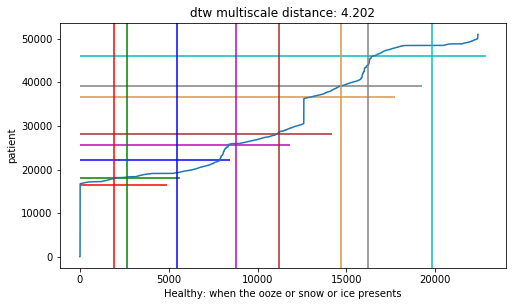

In [243]:
multiscale(x, y, xlabel, ylabel, time1_lst, time2_lst, sr, speech_x, speech_y)

# Bamboo - perfect alignment - Normal v.s. Normal 01 vs. 01_1 Bamboo walls are getting to be very popular

In [244]:
file1, seg1_1, seg1_2 = "01.wav", 3.4, 6
file2, seg2_1, seg2_2 = "01_1.wav", 2, 5
x, y, samplerate, speech_x, speech_y = make_samples(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, sr)
n_timestamps_1, n_timestamps_2 = len(x), len(y)
xlabel = "Bamboo walls are getting to be very popular - Normal 1" ;  ylabel = "Normal 01_1"
time1_lst = [3.46, 3.88, 4.16, 4.42, 4.77, 4.91, 5.21, 5.47] ;
time2_lst = [2.33, 2.63, 2.87, 3.12, 3.4, 3.57, 3.74, 4.06]

In [224]:
setup.play_samples(x, y, samplerate)

Avg err (s): 0.516. Median err (s): 0.544
Stretch speech: 0.153 
Stretch pause: 0.219. 
Stretch unaligned: 0.337. 
Stretch overall: 0.710.



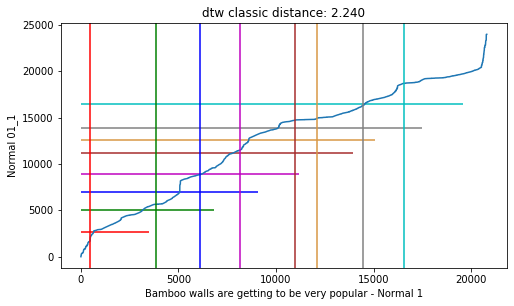

In [245]:
classic(x, y, xlabel, ylabel, time1_lst, time2_lst, sr, speech_x, speech_y)

Avg err (s): 0.406. Median err (s): 0.490
Stretch speech: 0.139 
Stretch pause: 0.232. 
Stretch unaligned: 0.300. 
Stretch overall: 0.672.



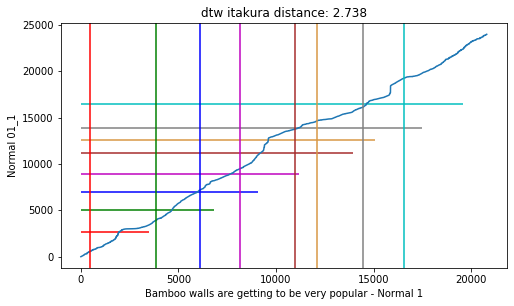

In [246]:
itakura(x, y, xlabel, ylabel, time1_lst, time2_lst, sr, speech_x, speech_y)

Avg err (s): 0.460. Median err (s): 0.529
Stretch speech: 0.158 
Stretch pause: 0.212. 
Stretch unaligned: 0.334. 
Stretch overall: 0.704.



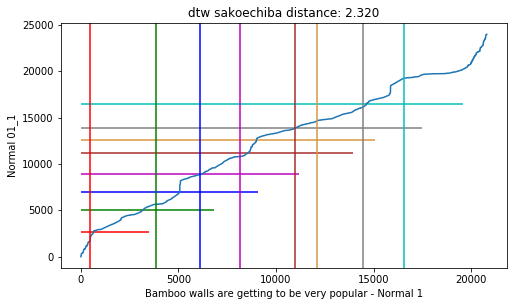

In [247]:
sakoechiba(x, y, xlabel, ylabel, time1_lst, time2_lst, sr, speech_x, speech_y)

Avg err (s): 0.062. Median err (s): 0.046
Stretch speech: 0.129 
Stretch pause: 0.242. 
Stretch unaligned: 0.296. 
Stretch overall: 0.666.



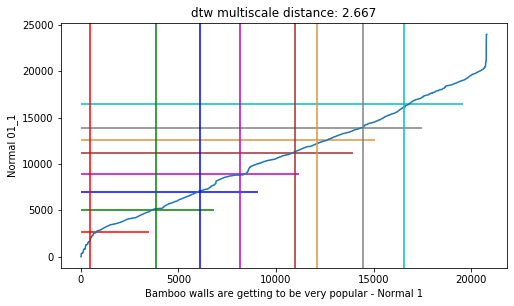

In [248]:
multiscale(x, y, xlabel, ylabel, time1_lst, time2_lst, sr, speech_x, speech_y)

# Bamboo - perfect alignment - Normal v.s. Normal 01 vs. 01_2

In [249]:
file1, seg1_1, seg1_2 = "01.wav", 3.4, 6
file2, seg2_1, seg2_2 = "01_2.wav", 2, 5
x, y, samplerate, speech_x, speech_y = make_samples(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, sr)
n_timestamps_1, n_timestamps_2 = len(x), len(y)

xlabel = "Bamboo walls are getting to be very popular - Normal 01" ;  ylabel = "Normal 01_2"
time1_lst = [3.46, 3.88, 4.16, 4.42, 4.77, 4.91, 5.21, 5.47] ;
time2_lst = [2.28, 2.72, 2.93, 3.18, 3.51, 3.66, 3.84, 4.11]

In [250]:
setup.play_samples(x, y, samplerate)

Avg err (s): 0.186. Median err (s): 0.126
Stretch speech: 0.110 
Stretch pause: 0.440. 
Stretch unaligned: 0.183. 
Stretch overall: 0.734.



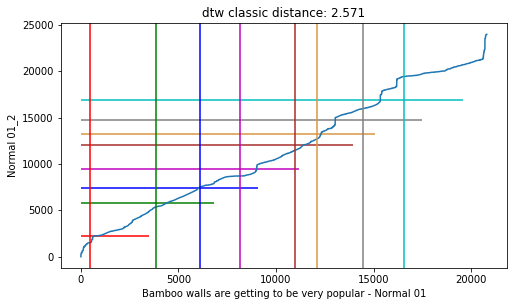

In [251]:
classic(x, y, xlabel, ylabel, time1_lst, time2_lst, sr, speech_x, speech_y)

Avg err (s): 0.226. Median err (s): 0.173
Stretch speech: 0.110 
Stretch pause: 0.398. 
Stretch unaligned: 0.219. 
Stretch overall: 0.727.



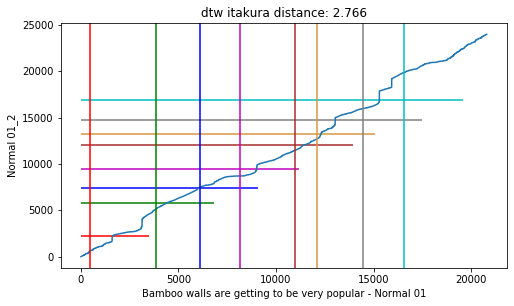

In [252]:
itakura(x, y, xlabel, ylabel, time1_lst, time2_lst, sr, speech_x, speech_y)

Avg err (s): 0.186. Median err (s): 0.126
Stretch speech: 0.111 
Stretch pause: 0.439. 
Stretch unaligned: 0.183. 
Stretch overall: 0.733.



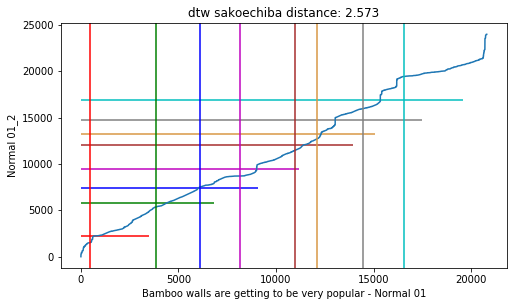

In [253]:
sakoechiba(x, y, xlabel, ylabel, time1_lst, time2_lst, sr, speech_x, speech_y)

Avg err (s): 0.267. Median err (s): 0.269
Stretch speech: 0.114 
Stretch pause: 0.505. 
Stretch unaligned: 0.121. 
Stretch overall: 0.739.



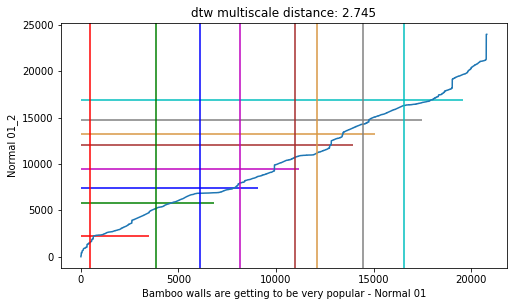

In [254]:
multiscale(x, y, xlabel, ylabel, time1_lst, time2_lst, sr, speech_x, speech_y)

# Bamboo - perfect alignment - Normal v.s. Normal 01 vs. 01_3

In [255]:
file1, seg1_1, seg1_2 = "01.wav", 3.4, 6
file2, seg2_1, seg2_2 = "01_3.wav", 2, 4.7
x, y, samplerate, speech_x, speech_y = make_samples(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, sr)
n_timestamps_1, n_timestamps_2 = len(x), len(y)

xlabel = "Bamboo walls are getting to be very popular - Normal 1" ;  ylabel = "Normal 01_3"
time1_lst = [3.46, 3.88, 4.16, 4.42, 4.77, 4.91, 5.21, 5.47] ;
time2_lst = [2.06, 2.45, 2.7, 2.94, 3.23, 3.41, 3.62, 3.98];

In [256]:
setup.play_samples(x, y, samplerate)

Avg err (s): 0.091. Median err (s): 0.073
Stretch speech: 0.125 
Stretch pause: 0.377. 
Stretch unaligned: 0.111. 
Stretch overall: 0.613.



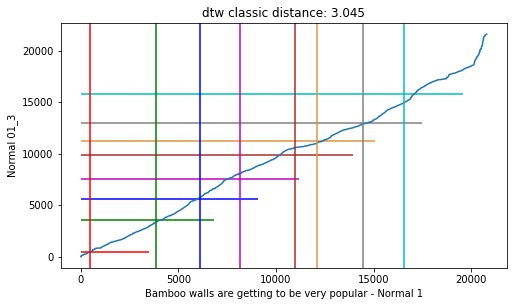

In [257]:
classic(x, y, xlabel, ylabel, time1_lst, time2_lst, sr, speech_x, speech_y)

Avg err (s): 0.424. Median err (s): 0.476
Stretch speech: 0.113 
Stretch pause: 0.319. 
Stretch unaligned: 0.221. 
Stretch overall: 0.654.



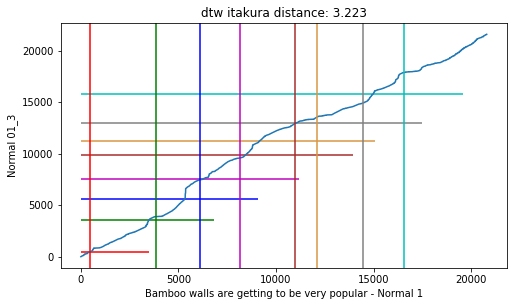

In [258]:
itakura(x, y, xlabel, ylabel, time1_lst, time2_lst, sr, speech_x, speech_y)

Avg err (s): 0.082. Median err (s): 0.073
Stretch speech: 0.124 
Stretch pause: 0.376. 
Stretch unaligned: 0.115. 
Stretch overall: 0.614.



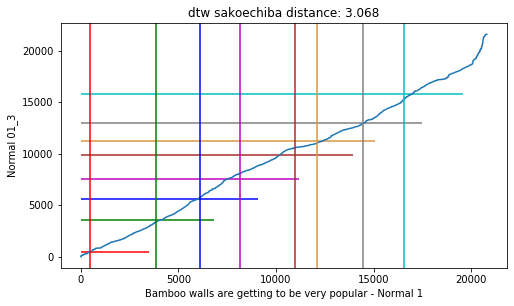

In [259]:
sakoechiba(x, y, xlabel, ylabel, time1_lst, time2_lst, sr, speech_x, speech_y)

Avg err (s): 0.098. Median err (s): 0.082
Stretch speech: 0.127 
Stretch pause: 0.374. 
Stretch unaligned: 0.109. 
Stretch overall: 0.610.



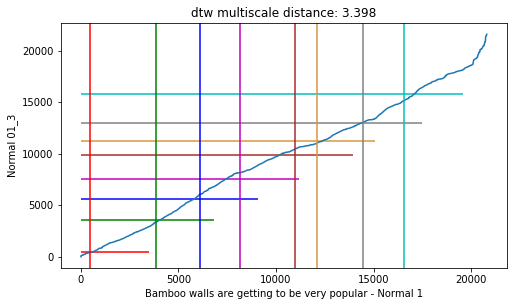

In [260]:
multiscale(x, y, xlabel, ylabel, time1_lst, time2_lst, sr, speech_x, speech_y)

# Bamboo - perfect alignment - Normal v.s. Normal 01_2 vs. 01_3

In [261]:
file1, seg1_1, seg1_2 = "01_2.wav", 2, 4.15
file2, seg2_1, seg2_2 = "01_3.wav", 2, 4
x, y, samplerate, speech_x, speech_y = make_samples(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, sr)
n_timestamps_1, n_timestamps_2 = len(x), len(y)

xlabel = "Bamboo walls are getting to be very popular - Normal 01_2" ;  ylabel = "Normal 01_3"

time1_lst = [2.28, 2.72, 2.93, 3.18, 3.51, 3.66, 3.84, 4.11]
time2_lst = [2.06, 2.45, 2.7, 2.94, 3.23, 3.41, 3.62, 3.98];

Avg err (s): 0.682. Median err (s): 0.807
Stretch speech: 0.203 
Stretch pause: 0.262. 
Stretch unaligned: 0.296. 
Stretch overall: 0.762.



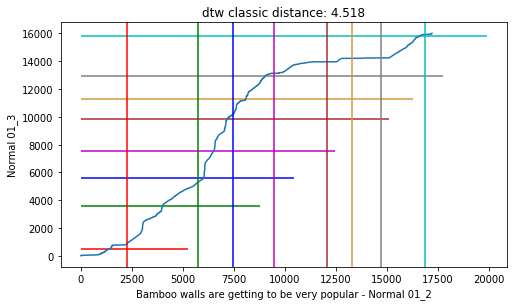

In [262]:
classic(x, y, xlabel, ylabel, time1_lst, time2_lst, sr, speech_x, speech_y)

Avg err (s): 0.359. Median err (s): 0.405
Stretch speech: 0.160 
Stretch pause: 0.268. 
Stretch unaligned: 0.294. 
Stretch overall: 0.721.



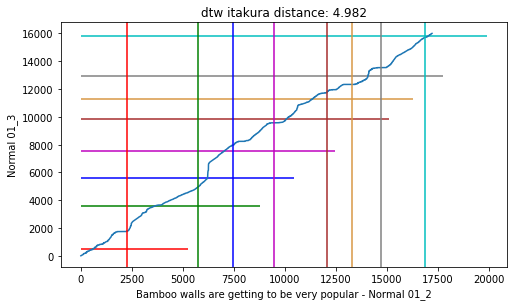

In [263]:
itakura(x, y, xlabel, ylabel, time1_lst, time2_lst, sr, speech_x, speech_y)

Avg err (s): 0.209. Median err (s): 0.101
Stretch speech: 0.178 
Stretch pause: 0.294. 
Stretch unaligned: 0.246. 
Stretch overall: 0.718.



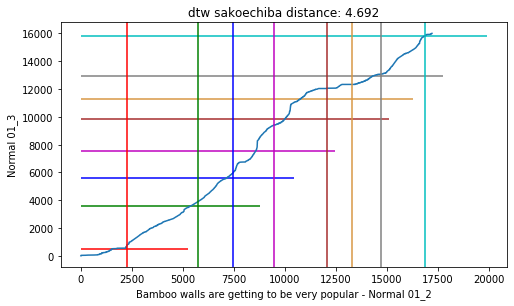

In [264]:
sakoechiba(x, y, xlabel, ylabel, time1_lst, time2_lst, sr, speech_x, speech_y)

In [265]:
multiscale(x, y, xlabel, ylabel, time1_lst, time2_lst, sr, speech_x, speech_y)

IndexError: index 17195 is out of bounds for axis 1 with size 17195

# Bamboo - perfect alignment - Normal v.s. Normal 01_1 vs. 01_2

In [266]:
file1, seg1_1, seg1_2 = "01_1.wav", 2, 4.1
file2, seg2_1, seg2_2 = "01_2.wav", 2, 4.15
x, y, samplerate, speech_x, speech_y = make_samples(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, sr)
n_timestamps_1, n_timestamps_2 = len(x), len(y)
time1_lst = [2.33, 2.63, 2.87, 3.12, 3.4, 3.57, 3.74, 4.06]
time2_lst = [2.28, 2.72, 2.93, 3.18, 3.51, 3.66, 3.84, 4.11]

xlabel = "Bamboo walls are getting to be very popular - Normal 01_1" ;  ylabel = "Normal 01_2"

Avg err (s): 0.693. Median err (s): 0.841
Stretch speech: 0.264 
Stretch pause: 0.187. 
Stretch unaligned: 0.277. 
Stretch overall: 0.728.



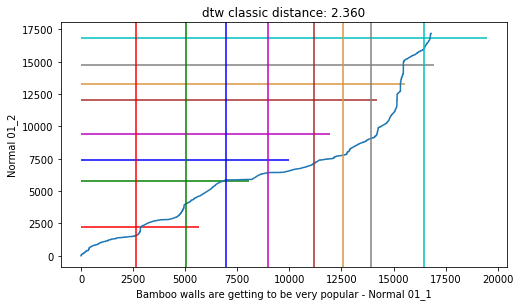

In [267]:
classic(x, y, xlabel, ylabel, time1_lst, time2_lst, sr, speech_x, speech_y)

Avg err (s): 0.096. Median err (s): 0.073
Stretch speech: 0.177 
Stretch pause: 0.170. 
Stretch unaligned: 0.298. 
Stretch overall: 0.645.



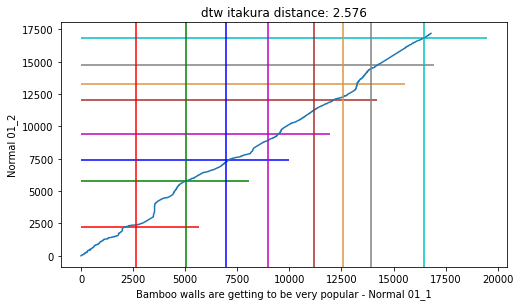

In [268]:
itakura(x, y, xlabel, ylabel, time1_lst, time2_lst, sr, speech_x, speech_y)

Avg err (s): 0.115. Median err (s): 0.097
Stretch speech: 0.194 
Stretch pause: 0.178. 
Stretch unaligned: 0.302. 
Stretch overall: 0.674.



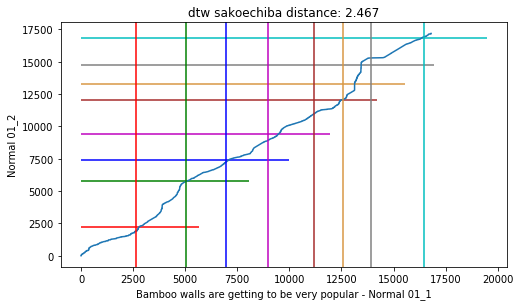

In [269]:
sakoechiba(x, y, xlabel, ylabel, time1_lst, time2_lst, sr, speech_x, speech_y)

Avg err (s): 0.120. Median err (s): 0.087
Stretch speech: 0.191 
Stretch pause: 0.203. 
Stretch unaligned: 0.279. 
Stretch overall: 0.673.



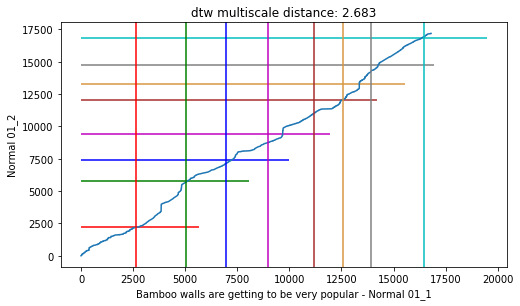

In [270]:
multiscale(x, y, xlabel, ylabel, time1_lst, time2_lst, sr, speech_x, speech_y)

# Bamboo - perfect alignment - Normal v.s. Normal 01_1 vs. 01_3

In [271]:
file1, seg1_1, seg1_2 = "01_1.wav", 2, 4.1
file2, seg2_1, seg2_2 = "01_3.wav", 2, 4

x, y, samplerate, speech_x, speech_y = make_samples(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, sr)
n_timestamps_1, n_timestamps_2 = len(x), len(y)
time1_lst = [2.33, 2.63, 2.87, 3.12, 3.4, 3.57, 3.74, 4.06]
time2_lst = [2.06, 2.45, 2.7, 2.94, 3.23, 3.41, 3.62, 3.98];
xlabel = "Bamboo walls are getting to be very popular - Normal 01_1" ;  ylabel = "Normal 01_3"

Avg err (s): 0.059. Median err (s): 0.065
Stretch speech: 0.249 
Stretch pause: 0.192. 
Stretch unaligned: 0.201. 
Stretch overall: 0.641.



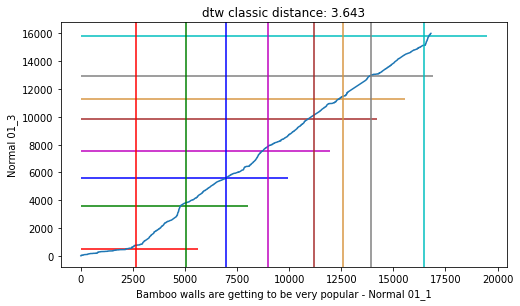

In [272]:
classic(x, y, xlabel, ylabel, time1_lst, time2_lst, sr, speech_x, speech_y)

Avg err (s): 0.114. Median err (s): 0.059
Stretch speech: 0.235 
Stretch pause: 0.157. 
Stretch unaligned: 0.236. 
Stretch overall: 0.628.



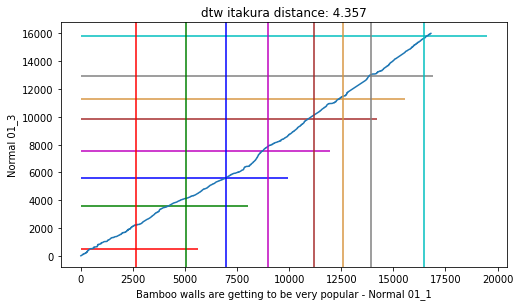

In [273]:
itakura(x, y, xlabel, ylabel, time1_lst, time2_lst, sr, speech_x, speech_y)

Avg err (s): 0.080. Median err (s): 0.073
Stretch speech: 0.246 
Stretch pause: 0.175. 
Stretch unaligned: 0.219. 
Stretch overall: 0.640.



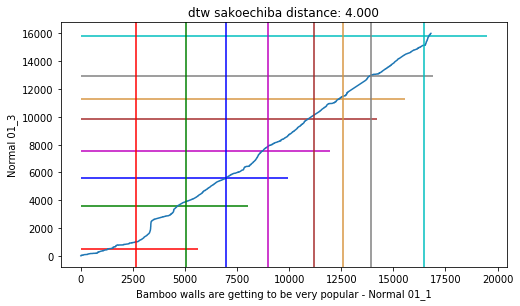

In [274]:
sakoechiba(x, y, xlabel, ylabel, time1_lst, time2_lst, sr, speech_x, speech_y)

In [275]:
multiscale(x, y, xlabel, ylabel, time1_lst, time2_lst, sr, speech_x, speech_y)

IndexError: index 16795 is out of bounds for axis 1 with size 16795

# Bamboo - normal vs. slightly slow: 01 vs 02: Bamboo walls are getting to be very popular

In [292]:
file1, seg1_1, seg1_2 = "01.wav", 2, 5
file2, seg2_1, seg2_2 = "02.wav", 1.7, 5

x, y, samplerate, speech_x, speech_y = make_samples(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, sr)
n_timestamps_1, n_timestamps_2 = len(x), len(y)
time1_lst = [2.33, 2.63, 2.87, 3.12, 3.4, 3.57, 3.74, 4.06]
time2_lst = [1.74, 2.42, 2.92, 3.52, 3.75, 3.88, 4.29, 4.48]
xlabel = "Bamboo walls are getting to be very popular - Normal 01" ;  ylabel = "Normal 02"

In [ ]:
setup.play_samples(x, y, samplerate)

Avg err (s): 2.343. Median err (s): 2.739
Stretch speech: 0.093 
Stretch pause: 0.495. 
Stretch unaligned: 0.166. 
Stretch overall: 0.754.



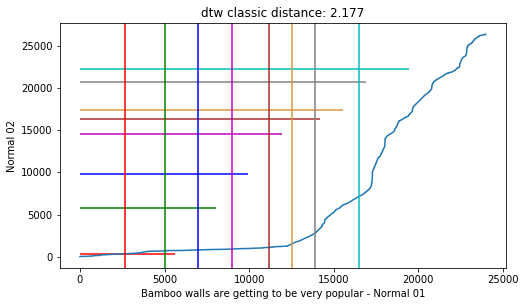

In [293]:
classic(x, y, xlabel, ylabel, time1_lst, time2_lst, sr, speech_x, speech_y)

Avg err (s): 0.931. Median err (s): 1.064
Stretch speech: 0.075 
Stretch pause: 0.269. 
Stretch unaligned: 0.384. 
Stretch overall: 0.729.



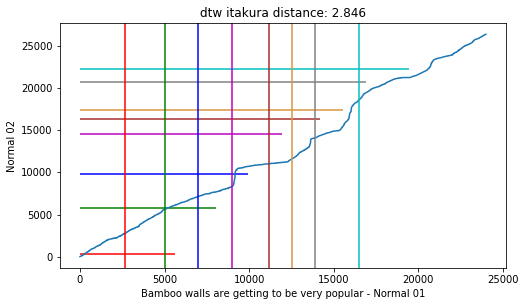

In [284]:
itakura(x, y, xlabel, ylabel, time1_lst, time2_lst, sr, speech_x, speech_y)

Avg err (s): 0.991. Median err (s): 1.033
Stretch speech: 0.088 
Stretch pause: 0.279. 
Stretch unaligned: 0.366. 
Stretch overall: 0.733.



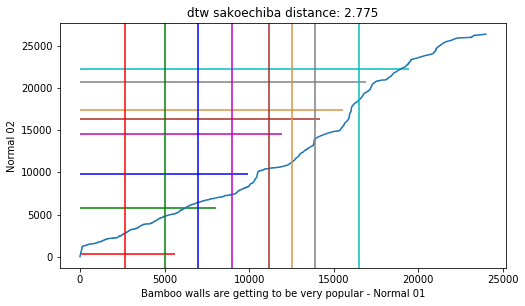

In [285]:
sakoechiba(x, y, xlabel, ylabel, time1_lst, time2_lst, sr, speech_x, speech_y)

Avg err (s): 2.367. Median err (s): 2.749
Stretch speech: 0.100 
Stretch pause: 0.479. 
Stretch unaligned: 0.181. 
Stretch overall: 0.760.



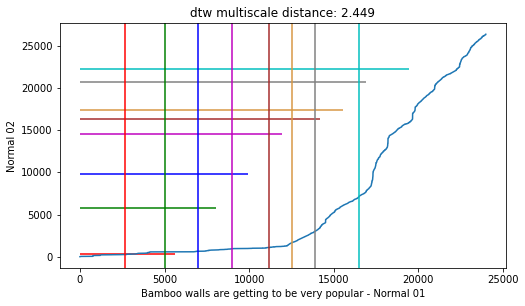

In [286]:
multiscale(x, y, xlabel, ylabel, time1_lst, time2_lst, sr, speech_x, speech_y)

# Bamboo - normal vs. short pauses: 01 vs 05: Bamboo walls are getting to be very popular

In [287]:
file1, seg1_1, seg1_2 = "01.wav", 2, 5
file2, seg2_1, seg2_2 = "05.wav", 1.4, 5.1

x, y, samplerate, speech_x, speech_y = make_samples(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, sr)
n_timestamps_1, n_timestamps_2 = len(x), len(y)
time1_lst = [2.33, 2.63, 2.87, 3.12, 3.4, 3.57, 3.74, 4.06]
time2_lst = [1.45, 1.83, 2.92, 3.17, 3.5, 3.64, 4.78, 5.09]

xlabel = "Bamboo walls are getting to be very popular - 01" ;  ylabel = "05"

In [ ]:
setup.play_samples(x, y, samplerate)

Avg err (s): 2.564. Median err (s): 2.756
Stretch speech: 0.107 
Stretch pause: 0.299. 
Stretch unaligned: 0.436. 
Stretch overall: 0.842.



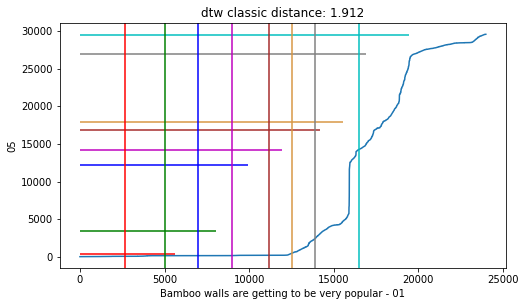

In [288]:
classic(x, y, xlabel, ylabel, time1_lst, time2_lst, sr, speech_x, speech_y)

Avg err (s): 1.211. Median err (s): 0.995
Stretch speech: 0.068 
Stretch pause: 0.389. 
Stretch unaligned: 0.280. 
Stretch overall: 0.737.



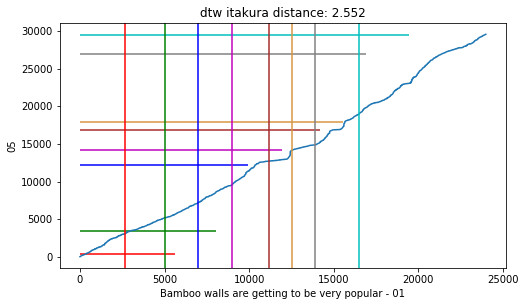

In [289]:
itakura(x, y, xlabel, ylabel, time1_lst, time2_lst, sr, speech_x, speech_y)

Avg err (s): 1.293. Median err (s): 1.238
Stretch speech: 0.073 
Stretch pause: 0.358. 
Stretch unaligned: 0.301. 
Stretch overall: 0.732.



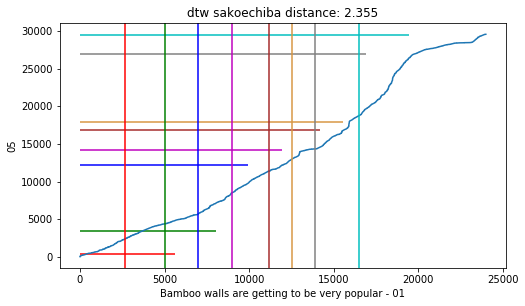

In [290]:
sakoechiba(x, y, xlabel, ylabel, time1_lst, time2_lst, sr, speech_x, speech_y)

Avg err (s): 2.623. Median err (s): 2.783
Stretch speech: 0.084 
Stretch pause: 0.449. 
Stretch unaligned: 0.305. 
Stretch overall: 0.838.



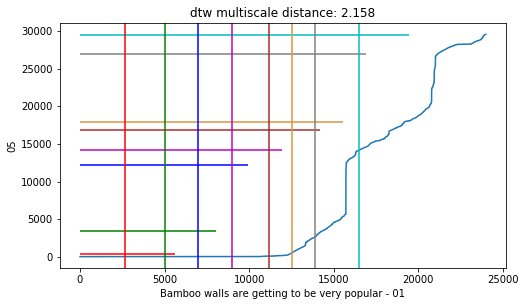

In [291]:
multiscale(x, y, xlabel, ylabel, time1_lst, time2_lst, sr, speech_x, speech_y)

# Bamboo - normal vs. repeat part of word + pauses: 01 vs pause_m01: Bamboo walls are getting to be very popular

In [ ]:
file1, seg1_1, seg1_2 = "01.wav", 2, 5
file2, seg2_1, seg2_2 = "pause_m01.wav", 1.5, 11.5

x, y, samplerate, speech_x, speech_y = make_samples(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, sr)
n_timestamps_1, n_timestamps_2 = len(x), len(y)
time1_lst = [2.33, 2.63, 2.87, 3.12, 3.4, 3.57, 3.74, 4.06]
time2_lst = [4.52, 5.11, 9.18, 9.45, 9.82, 9.95, 11.06, 11.30]

xlabel = "Bamboo walls are getting to be very popular - 01" ;  ylabel = "pause_m01"

In [ ]:
setup.play_samples(x, y, samplerate)

In [ ]:
classic(x, y, xlabel, ylabel, time1_lst, time2_lst, sr, speech_x, speech_y)

In [ ]:
itakura(x, y, xlabel, ylabel, time1_lst, time2_lst, sr, speech_x, speech_y)

In [ ]:
sakoechiba(x, y, xlabel, ylabel, time1_lst, time2_lst, sr, speech_x, speech_y)

In [ ]:
multiscale(x, y, xlabel, ylabel, time1_lst, time2_lst, sr, speech_x, speech_y)